# Data Generation
We assume the generator is composed of $k$ parts, each of which is generated by a diffeomorphic function $g_i:[0,1]^l \mapsto \mathbb{R}^m$. The final observation is simply the stacking of the individual parts, i.e., $g:[0,1)^{k\times l} \mapsto \mathbb{R}^{k\times m}$ with $g({\bf z}_1,{\bf z}_2,{\bf z}_3)=[g_1({\bf z}_1), g_2({\bf z}_2), g_3({\bf z}_3)]$.

We consider two different sampling strategies from the latent space:

1. **Random**: Sample uniformly from the full latent distribution $[0,1)^{k \times l}$.
2. **Diagonal**: Sample $\bf v$ uniformly from $[0,1)^l$ and then generate samples according to $g({\bf v},{\bf v},{\bf v})$.
2. **Orthogonal**: Sample $\bf v$ uniformly from $[0,1)^l$ and then generate samples according to $g({\bf v},\bm 0, \bm 0)$ for each latent dimension.

We follow [1,2,3] and design the mixing function as an MLP with
- 2 layers (hidden layer dimension $D$)
- leaky ReLU (with 0.2 negative slope) to ensure invertability
- $L_2$-normalized weight matrices with minimum condition number of 7500 uniformely distributed samples
- same number of units in all layers?
- what about bias?

---
- [1]: A. Hyvarinen and H. Morioka, “Nonlinear ICA of Temporally Dependent Stationary Sources,” in Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, Apr. 2017, pp. 460–469. Accessed: Jul. 06, 2022. [Online]. Available: https://proceedings.mlr.press/v54/hyvarinen17a.html
- [2] A. Hyvarinen and H. Morioka, “Unsupervised Feature Extraction by Time-Contrastive Learning and Nonlinear ICA,” in Advances in Neural Information Processing Systems, 2016, vol. 29. Accessed: Jul. 06, 2022. [Online]. Available: https://proceedings.neurips.cc/paper/2016/hash/d305281faf947ca7acade9ad5c8c818c-Abstract.html
- [3] J. Brady et al., "Provably Learning Object-Centric Representations"

In [9]:
import torch
print(torch.arange(4))
print(torch.randint(0, 4, (4, 1)))

tensor([0, 1, 2, 3])
tensor([[3],
        [0],
        [3],
        [1]])


In [16]:
import torch
_z = torch.rand(4,2)
print(_z)
mask = torch.stack([torch.arange(4), torch.randint(3, (4, 1)).squeeze()], dim=1).long()
print(mask)
z = torch.zeros(4,3,2)
z[mask.chunk(chunks=2, dim=1)] = _z.unsqueeze(1)
print(z)

tensor([[0.2987, 0.6347],
        [0.2199, 0.0218],
        [0.2024, 0.9009],
        [0.2377, 0.0119]])
tensor([[0, 2],
        [1, 1],
        [2, 2],
        [3, 2]])
tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.2987, 0.6347]],

        [[0.0000, 0.0000],
         [0.2199, 0.0218],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.2024, 0.9009]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.2377, 0.0119]]])


In [1]:
import math
import torch
import torch.nn as nn

def get_generators(k: int, l: int, m: int, D: int=50) -> list[torch.nn.Module]:
    return [build_generator(l, m, D) for _ in range(k)]


@torch.no_grad()
def get_regression_targets(n:int, k: int, l: int, generators: list[torch.nn.Module], sample_mode: str='random') -> tuple[torch.Tensor, torch.Tensor]:
    if sample_mode == 'random':
        z = torch.rand(n, k, l)
    elif sample_mode == 'diagonal':
        z = torch.repeat_interleave(torch.rand(n, l), k, dim=0)
        z = torch.reshape(z, (n, k, l))
    
    x = [torch.stack([generators[j](z[i][j]) for j in range(k)]) for i in range(n)]
    x = torch.stack(x)

    return z, x


def build_generator(l: int, m: int, D: int, slope: float=0.2) -> nn.Sequential:
    g = nn.Sequential(
        nn.Linear(l, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, m),
        nn.LeakyReLU(slope)
    )
    g.apply(init_min_cond)
    return g


# class Generator(torch.nn.Module):
#     def __init__(self, l: int, m: int, D: int):
#         super(Generator, self).__init__()
#         self.fc1 = nn.Linear(l, D)
#         self.relu1 = nn.LeakyReLU(0.2)
#         self.fc2 = nn.Linear(D, m)
#         self.relu2 = nn.LeakyReLU(0.2)
#         self.apply(init_min_cond)
    
#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.relu2(self.fc2(x))
#         return x


def init_min_cond(m: torch.nn.Module, n_samples: int=7500) -> torch.Tensor:
    if isinstance(m, nn.Linear):
        w = m.weight.data
        k = 1 / w.size(0)

        w = torch.nn.functional.normalize(w, p=2)
        cond = condition_number(w)

        for _ in range(n_samples):
            _w = 2 * math.sqrt(k) * torch.rand(w.size()) - math.sqrt(k)
            _w = nn.functional.normalize(_w, p=2)
            _cond = condition_number(_w)

            if _cond < cond:
                w = _w
                cond = _cond
        
        m.weight.data = w


def condition_number(t: torch.Tensor) -> float:
    return torch.norm(t, p=2) / torch.norm(torch.pinverse(t), p=2)


# Models
We consider two feedforward models:
1. An appropriately sized MLP that maps the full $\mathbb{R}^{k \times m}$ to the full latent space $\mathbb [0, 1)^{k\times l}$.
2. A “compositional” model consisting of $k$ MLPs $f_i({\bf x}): \mathbb{R}^{k \times m}\mapsto [0,1)^{l}$ that each map to a subpart of the latents. Most importantly, the first MLP $f_1$ receives $[g_1({\bf z}_1),{\bf 0},{\bf 0}]$ as an input, the second MLP receives $[{\bf 0},g_2({\bf z}_2),{\bf 0}]$, and so forth. Doing that ensures that the model is compositional by design, but the input dimension is as close as possible to 1 (to avoid confounders).

We follow [1] and design the model with
- 2 layers
- hidden layer of size $D = 120$ for the MLP and $D_i = \frac{D}{k}$ for the models in the compositional MLP to roughly match the number of parameters
- LeakyReLU with slope 0.2

---
[1] J. Brady et al., "Provably Learning Object-Centric Representations"

In [2]:
def build_MLP(d_in: int, d_out: int, D: int=120, slope: float=0.2) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(d_in, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, d_out),
        nn.LeakyReLU(slope)
    )


def MLP(k: int, l: int, m: int, D: int=120):
    return build_MLP(k * m, k * l, D)


class CompositionalMLP(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120):
        super(CompositionalMLP, self).__init__()
        self.k = k
        self.models = nn.ModuleList([build_MLP(k * m, l, round(D / k)) for _ in range(k)])
    
    def forward(self, x):
        x = x.reshape(x.size(0), self.k, -1)
        out = []
        for i in range(len(self.models)):
            x_i = torch.zeros_like(x)
            x_i[:, i, :] = x[:, i, :]
            x_i = torch.flatten(x_i, start_dim = 1)
            out.append(self.models[i](x_i))
        return torch.cat(out, dim=1)
    
    
        

# Train & Test
We do simple supervised regression and evaluate the $R^2$ distance on random samples.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import R2Score
from tqdm import tqdm


# could be more efficient with torch.utils.data.TensorDataset, but I couldn't be assed to look up the documentation
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n: int, k: int, l: int, generators: list[torch.nn.Module], sample_mode: str='random'):
        super(Dataset, self).__init__()
        self.n = n
        self.z, self.x = get_regression_targets(n, k, l, generators, sample_mode)
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx]


def train(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001, epochs: int=10):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        cum_loss = 0

        for batch, data in enumerate(trainloader, 0):
            x, z = data

            optimizer.zero_grad()

            out = model(torch.flatten(x, start_dim=1))
            loss = criterion(out, torch.flatten(z, start_dim=1))
            cum_loss += loss
            loss.backward()
            optimizer.step()
        
        cum_loss /= (batch + 1)
    
    return cum_loss


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        out = model(torch.flatten(x, start_dim=1))
        loss = criterion(out, torch.flatten(z, start_dim=1))
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss


@torch.no_grad()
def test(model: torch.nn.Module, testloader: torch.utils.data.DataLoader):
    cum_score = 0

    for batch, data in enumerate(testloader, 0):
        x, z = data
        out = model(torch.flatten(x, start_dim=1))
        r2score = R2Score(out.size(1))
        score = r2score(out, torch.flatten(z, start_dim=1))
        cum_score += score
    
    cum_score /= (batch + 1)
    return cum_score

In [4]:
import copy

k = 4
l = 2
m = 10

torch.manual_seed(0)

print('Build generators...')
g = get_generators(k, l, m)

Build generators...


In [7]:
print('Build test data...')
te_ds = Dataset(1000, k, l, g, 'random')
te_ldr = torch.utils.data.DataLoader(te_ds, batch_size=1000, shuffle=True)

Build test data...


In [13]:
bs = 4
nb = int(2**10 / bs)

res = []
for log_n in range(10):
    n = 2**log_n
    print(f'n={n:4d}')

    print('Build train data...')
    tr_ds_rand = Dataset(n, k, l, g, 'random')
    tr_ds_diag = Dataset(n, k, l, g, 'diagonal')

    tr_ldr_rand = torch.utils.data.DataLoader(tr_ds_rand, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_rand, num_samples=nb), bs, False))
    tr_ldr_diag = torch.utils.data.DataLoader(tr_ds_diag, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(tr_ds_diag, num_samples=nb), bs, False))

    print('Build models...')
    mlp_rand = MLP(k, l, m)
    mlp_diag = copy.deepcopy(mlp_rand)
    cmlp_rand = CompositionalMLP(k, l, m)
    cmlp_diag = copy.deepcopy(cmlp_rand)

    print('Train models...')
    for i in tqdm(range(100)):
        res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'normal', 'sampling': 'random', 'val': train_iter(mlp_rand, tr_ldr_rand).item()})
        res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'normal', 'sampling': 'random', 'val': test(mlp_rand, te_ldr).item()})
        res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'normal', 'sampling': 'diagonal', 'val': train_iter(mlp_diag, tr_ldr_diag).item()})
        res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'normal', 'sampling': 'diagonal', 'val': test(mlp_diag, te_ldr).item()})
        res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'compositional', 'sampling': 'random', 'val': train_iter(cmlp_rand, tr_ldr_rand).item()})
        res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'compositional', 'sampling': 'random', 'val': test(cmlp_rand, te_ldr).item()})
        res.append({'metric': 'train loss', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'compositional', 'sampling': 'diagonal', 'val': train_iter(cmlp_diag, tr_ldr_diag).item()})
        res.append({'metric': 'test R²', 'n samples': n, 'n batches': (i+1)*nb, 'model': 'compositional', 'sampling': 'diagonal', 'val': test(cmlp_diag, te_ldr).item()})
        # print(f'  {i*nb:5d}\tloss: {loss:2.4f}\tR²: {score:2.4f}')
        # train(mlp_diag, tr_ldr_diag, epochs=e)
        # train(cmlp_rand, tr_ldr_rand, epochs=e)
        # train(cmlp_diag, tr_ldr_diag, epochs=e)

n=   1
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


n=   2
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


n=   4
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


n=   8
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


n=  16
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


n=  32
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


n=  64
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


n= 128
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


n= 256
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


n= 512
Build train data...
Build models...
Train models...


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


In [22]:
import pandas as pd
res_df = pd.DataFrame.from_dict(res)

In [39]:
import pickle as pk
with open(r'res_i100.pkl', 'wb') as f:
    pk.dump(res_df, f)

In [23]:
res_df.head()

,metric,n samples,n batches,model,sampling,val
0,train loss,1,256,normal,random,0.277961
1,test R²,1,256,normal,random,-0.462060
2,train loss,1,256,normal,diagonal,0.002561
3,test R²,1,256,normal,diagonal,-2.542403
4,train loss,1,256,compositional,random,0.359215


In [28]:
res_df.loc[res_df['metric'] == 'test R²']

,metric,n samples,n batches,model,sampling,val
1,test R²,1,256,normal,random,-0.462060
3,test R²,1,256,normal,diagonal,-2.542403
5,test R²,1,256,compositional,random,-1.178063
7,test R²,1,256,compositional,diagonal,-2.153308
9,test R²,1,512,normal,random,-0.558755
...,...,...,...,...,...,...
7991,test R²,512,25344,compositional,diagonal,0.553315
7993,test R²,512,25600,normal,random,0.700365
7995,test R²,512,25600,normal,diagonal,0.173520
7997,test R²,512,25600,compositional,random,0.556171


<AxesSubplot:xlabel='n batches', ylabel='val'>

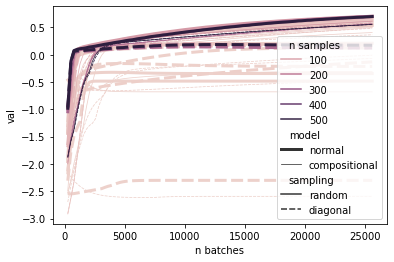

In [30]:
import seaborn as sb
sb.lineplot(data=res_df.loc[res_df['metric'] == 'test R²'], x='n batches', y='val', hue='n samples', size='model', style='sampling')

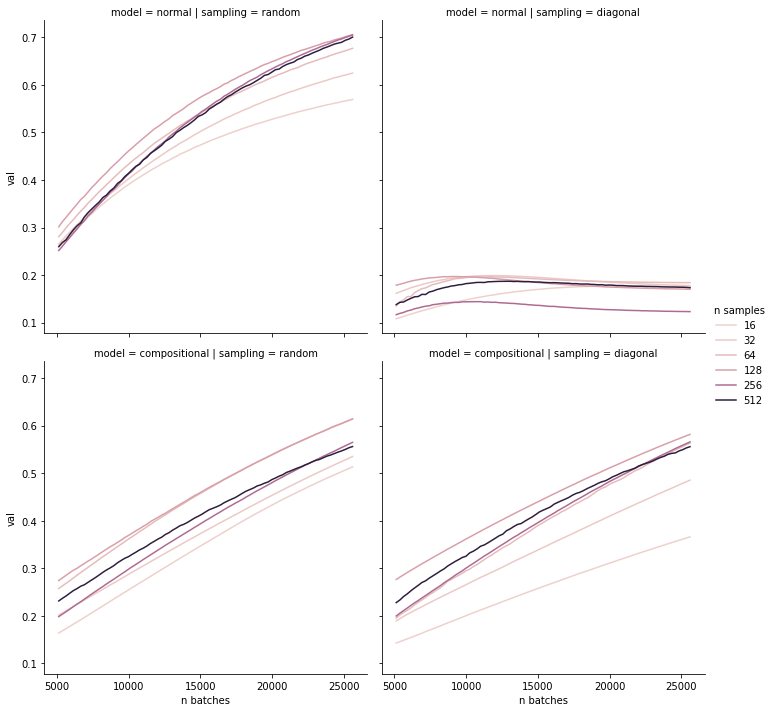

In [37]:
import seaborn as sb
sb.relplot(data=res_df.loc[(res_df['metric'] == 'test R²') & (res_df['n batches'] > 5000) & (res_df['n samples'] > 8)], x='n batches', y='val', hue='n samples', row='model', col='sampling', kind='line')

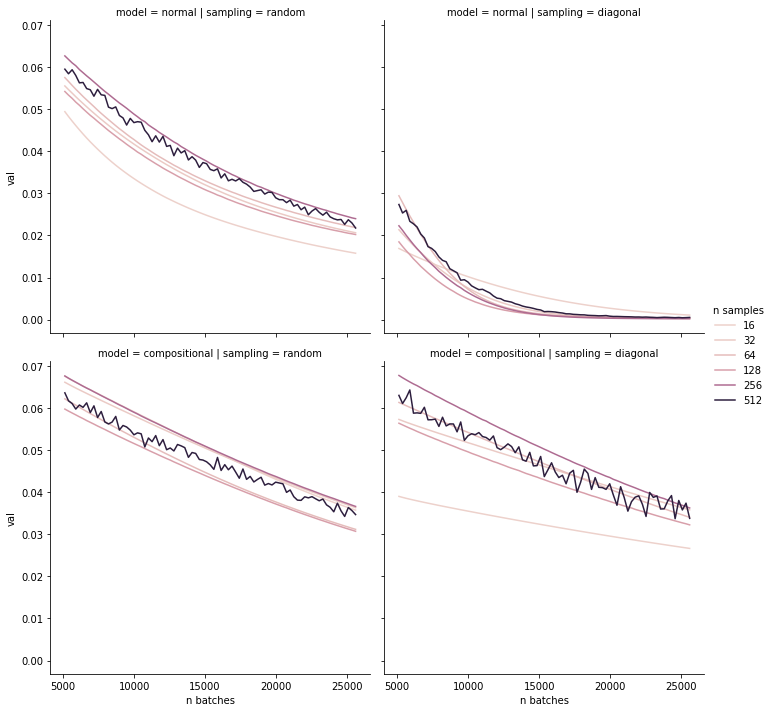

In [38]:
import seaborn as sb
sb.relplot(data=res_df.loc[(res_df['metric'] == 'train loss') & (res_df['n batches'] > 5000) & (res_df['n samples'] > 8)], x='n batches', y='val', hue='n samples', row='model', col='sampling', kind='line')